11
98


Text(0, 0.5, 'Amount of adjustments')

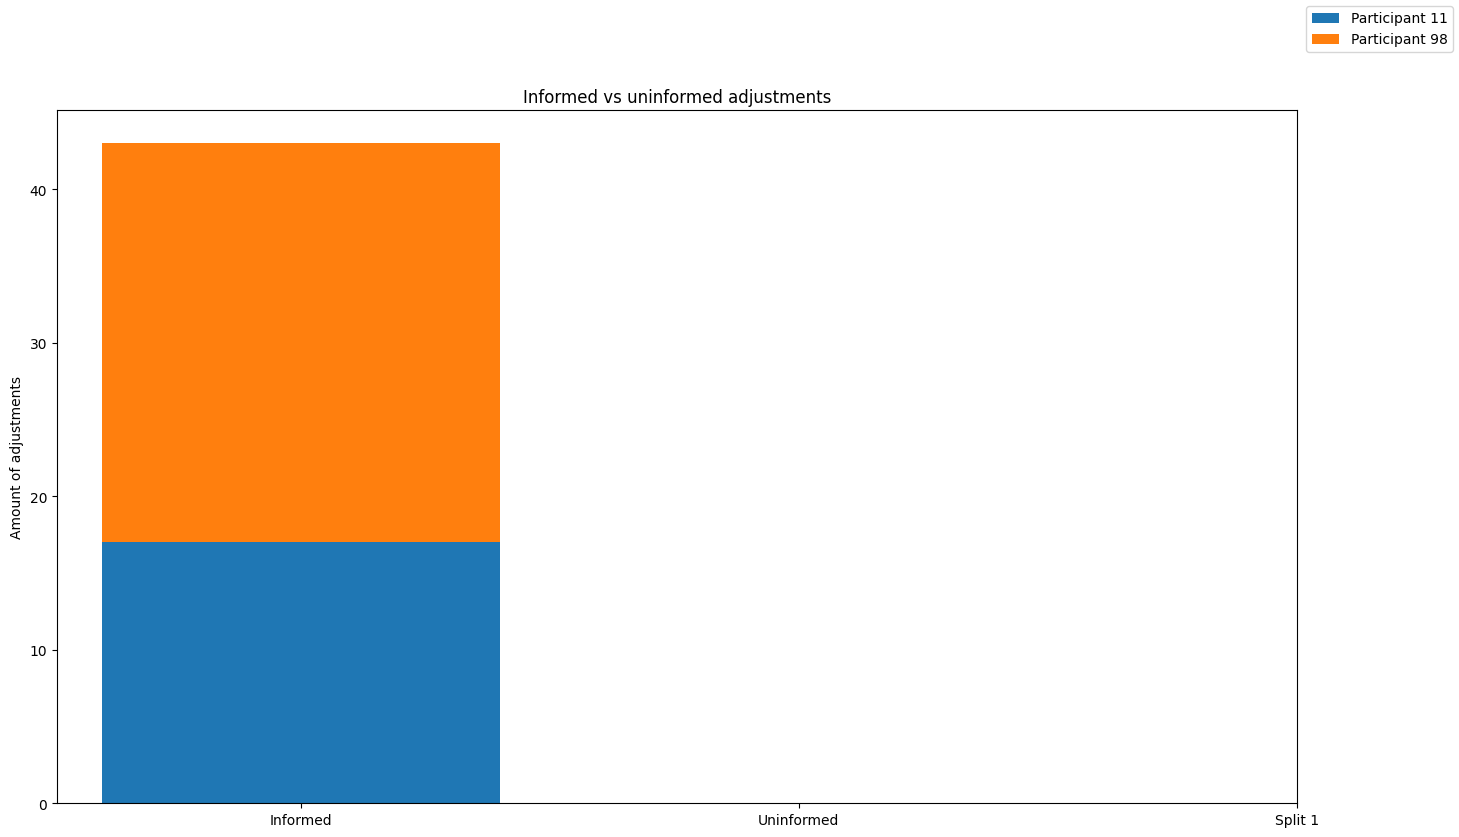

In [35]:
import numpy as np
from utils import Events
import matplotlib.pyplot as plt
from peewee import fn

INFORMED_TREATMENTS = ["Treatment 2,1", "Treatment 2,2", "Treatment 2,3"]
UNINFORMED_TREATMENTS = ["Treatment 2,4", "Treatment 2,5", "Treatment 2,6"]
SPLIT1_TREATMENTS = ["Treatment 1,1", "Treatment 1,2", "Treatment 1,3", "Treatment 1,4"]

UNINFORMED_PARTICIPANTS = (
    Events.select(
        Events.participant_id,
        fn.COUNT().alias("event_count"),
    )
    .where(
        (Events.event.startswith("SET_"))
        & Events.participant_id.in_(
            Events.select(Events.participant_id).where(
                (Events.new_value.in_(UNINFORMED_TREATMENTS))
            )
        )
    )
    .group_by(Events.participant_id)
)


INFORMED_PARTICIPANTS = (
    Events.select(
        Events.participant_id,
        fn.COUNT().alias("event_count"),
    )
    .where(
        (Events.event.startswith("SET_"))
        & Events.participant_id.in_(
            Events.select(Events.participant_id).where(
                (Events.new_value.in_(INFORMED_TREATMENTS))
            )
        )
    )
    .group_by(Events.participant_id)
)

SPLIT1_PARTICIPANTS = (
    Events.select(
        Events.participant_id,
        fn.COUNT().alias("event_count"),
    )
    .where(
        (Events.event.startswith("SET_"))
        & Events.participant_id.in_(
            Events.select(Events.participant_id).where(
                (Events.new_value.in_(SPLIT1_TREATMENTS))
            )
        )
    )
    .group_by(Events.participant_id)
)

fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Informed vs uninformed adjustments")

x = np.arange(INFORMED_PARTICIPANTS.count() + UNINFORMED_PARTICIPANTS.count())  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

bottom = 0
# Make a stacked bar chart with the amount of adjustments per participant
# For informed participants
for p in INFORMED_PARTICIPANTS:
    ax.bar(
        label=f"Participant {p.participant_id}",
        x="Informed",
        height=p.event_count,
        bottom=bottom,
    )
    bottom += p.event_count

bottom = 0
# For uninformed participants
for p in UNINFORMED_PARTICIPANTS:
    ax.bar(
        label=f"Uninformed {p.participant_id}",
        x="Uninformed",
        height=p.event_count,
        bottom=bottom,
    )
    bottom += p.event_count
ax.bar(x="Uninformed", height=0)


# bottom = 0
# for p in SPLIT1_PARTICIPANTS:
#     ax.bar(
#         label=f"Participant {p.participant_id}",
#         x="Split 1",
#         height=p.event_count,
#         bottom=bottom,
#     )
#     bottom += p.event_count


ax.set_xticks(["Informed", "Uninformed", "Split 1"])

fig.legend()

ax.set_ylabel("Amount of adjustments")

In [ ]:
for participant in INFORMED_PARTICIPANTS:
    # get all of this participant's events
    all_events = Events.select().where(Events.participant_id == participant).order_by(Events.time.asc())

    # get the first OPEN_BOOK event for this participant
    open_book_event = all_events.where(Events.event == 'OPEN_BOOK').order_by(Events.time.asc()).limit(1)[0]

    # get the first CLOSE_BOOK event for this participant
    close_book_event = all_events.where(Events.event == 'CLOSE_BOOK').order_by(Events.time.asc()).limit(1)[0]

    events_for_book1 = all_events.where(Events.participant_id == participant).where(Events.time.between(open_book_event.time, close_book_event.time)).order_by(Events.time.asc())

    number_changes_book1 = len([event for event in events_for_book1 if event.event.startswith('SET_')])